<a href="https://colab.research.google.com/github/Gh5al/VAT_ITA_classification/blob/main/nlp_pw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import random
import torch
from sklearn.model_selection import train_test_split
import random
import gc
import transformers
from tqdm import tqdm, trange
from typing import Callable, Dict, List, Tuple
from timeit import default_timer as timer
from transformers import EncoderDecoderModel, AutoTokenizer, PreTrainedTokenizer, BatchEncoding
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import os
import json

# Loading data

In [2]:
def uniform(el):
    """
    Handles the values for multi-value attributes, splitting to list if necessary
    If the input is a list or transformed to a list, values are sorted

    Args:
        el (str or list): The attribute value

    Returns:
        str or list: The attribute value sorted if it is a list, the attribute value otherwise
    """
    if el == el:  # NaN is different from NaN, np.isnan and pd.isna don't work
        if '|' in el:
            el = sorted(el.split('|'))
        elif isinstance(el, list):
            el = sorted(el)
    return el

DATAFRAMES_PATH = '/kaggle/input/nlp-pw' if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') else './Dataframes'

def create_df_annotations(path: str, language: str, dataset: str):
    """
    Load the dataset + create and save to file a dataframe with the annotations of the arguments.

    Args:
        path (str): path of the folder containing the JSON files
        dataset (str): One of [vat, tp, ecj]
    """

    pkl_file_path = f"{DATAFRAMES_PATH}/arg_annotations_{language}_{dataset}.pkl.xz"
    if os.path.isfile(pkl_file_path):
        return pd.read_pickle(pkl_file_path)

    temp = []
    files = os.listdir(path)
    files.sort()

    for filename in files:
        if not filename.endswith('.json'):
            print(f"Skipping '{filename}'")
        else:
            print(f"Loading '{filename}'")
            with open(os.path.join(path, filename), 'r', encoding='utf8') as f:
                data = json.load(f)
                annotations = data["annotations"]
                last_full_chain_id = None
                last_text = None

                for annotation in annotations:
                    if annotation["name"] != 'conc' and annotation["name"] != 'prem':
                        continue # Ignore intro, nreg, judoff, ...
                    #document = annotation["document"]
                    document = data["document"]["name"]
                    name = annotation["name"]
                    _id = annotation["_id"]
                    argument_chain_id = _id[0]
                    full_chain_id = f'{document}_{argument_chain_id}'
                    last_full_chain_id = full_chain_id
                    incremental_num = _id[1:]
                    text = data["document"]["plainText"][int(annotation["start"]):int(annotation["end"])]
                    last_text = text
                    # attribute extraction, NaN if that attribute is not present
                    T = uniform(annotation["attributes"].get("T", np.nan))
                    SUP = uniform(annotation["attributes"].get("SUP", np.nan))
                    SFF = uniform(annotation["attributes"].get("SFF", np.nan))
                    ATT = uniform(annotation["attributes"].get("ATT", np.nan))
                    INH = uniform(annotation["attributes"].get("INH", np.nan))
                    REPH = uniform(annotation["attributes"].get("REPH", np.nan))
                    S = uniform(annotation["attributes"].get("S", np.nan))

                    text = text.replace('\n','').lstrip('‘’\'\n0123456789.-–…;;) ').rstrip('‘’\'\n.;; ')

                    temp.append([
                        document,
                        name,
                        _id,
                        argument_chain_id,
                        incremental_num,
                        text,
                        T,
                        SUP,
                        SFF,
                        ATT,
                        INH,
                        REPH,
                        S,
                        full_chain_id,
                        last_text if last_full_chain_id == full_chain_id else None,
                    ])
    # df creation
    df = pd.DataFrame(temp,
                      columns=['Document', 'Name', 'Id', 'Chain', 'Num', 'Text', 'Type', 'SUP', 'SFF',
                               'ATT', 'INH', 'REPH', 'Scheme', 'FullChainID', 'Previous'])

    df.to_pickle(pkl_file_path)
    df.to_csv(f"{DATAFRAMES_PATH}/arg_annotations_{language}_{dataset}.csv")
    return df


df = create_df_annotations('Data/Dataset/VAT_ITA', 'italian', 'vat')


In [3]:
df.describe()

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
count,3311,3311,3311,3311,3311,3311,2910,1088,82,66,25,89,1314,3311,3311
unique,225,2,264,10,98,3163,3,428,48,32,19,31,63,367,3186
top,2016_202_VAT_OPAM_2_1_PS_AN,prem,A2,A,2,,F,A2,A7,A8,A10,A1,Rule,2016_202_VAT_OPAM_2_1_PS_AN_A,
freq,79,2910,221,2348,365,12,1572,54,6,8,3,29,349,79,12


In [4]:
df.head(10)

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A1,A,1,"In via preliminare, il Collegio prende in cons...",F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"In via preliminare, il Collegio prende in con..."
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,NaN,NaN,Rule,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'..."
2,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,NaN,NaN,Itpr,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Se il ricorso non è stato\n proposto da o ...
3,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A4,A,4,Nel caso di specie solo la ILDS ha presentato ...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Nel caso di specie solo la ILDS ha presentato...
4,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A5,A,5,come espressamente richiesto nel ricorso in...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,come\n espressamente richiesto nel ricorso...
5,2013_40_VAT_OPAM_2_REM_MB_PS_AN,conc,A6,A,6,"Poiché ciò non è avvenuto, risulta applicabile...",NaN,"[A1, A2, A3]","[A4, A5]",NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"\n Poiché ciò non è avvenuto, risulta appl..."
6,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,NaN,NaN,Rule,2018_847_VAT_OP_2_-1_MB_AF_AN_A,Secondo condivisa e costante giurisprudenza (C...
7,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,NaN,NaN,Itpr,2018_847_VAT_OP_2_-1_MB_AF_AN_A,"Tuttavia, nel caso qui in esame, la Comm/ne no..."
8,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,NaN,NaN,Prec,2018_847_VAT_OP_2_-1_MB_AF_AN_A,A tal proposito si ricorda che la Corte cost. ...
9,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A4,A,4,Inoltre (Cass. 2.9.2013 n. 20064) “qualora la ...,L,NaN,NaN,NaN,NaN,NaN,Prec,2018_847_VAT_OP_2_-1_MB_AF_AN_A,Inoltre (Cass. 2.9.2013 n. 20064) “qualora la ...


Example of row with multiple attribute values:

In [5]:
df[df["FullChainID"] == "2021_2717_VAT_OPAM_2_1_FG_PS_AN_A"]

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
3213,2021_2717_VAT_OPAM_2_1_FG_PS_AN,conc,A1,A,1,Passando all'esame del motivo di appello con c...,NaN,A13,NaN,NaN,NaN,NaN,NaN,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,Passando all'esame del motivo di appello con c...
3214,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A2,A,2,"Sul punto, come è noto, giova ricordare che la...",L,NaN,NaN,NaN,NaN,NaN,Princ,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Sul punto, come è noto, giova ricordare che la..."
3215,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A3,A,3,"Con riguardo al primo profilo, dall'esame degl...","[F, L]",NaN,NaN,NaN,NaN,NaN,Rule,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Con riguardo al primo profilo, dall'esame degl..."
3216,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A4,A,4,Per quanto riguarda il secondo profilo (come r...,F,"[A5, A6]",NaN,NaN,NaN,NaN,NaN,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,Per quanto riguarda il secondo profilo (come r...
3217,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A5,A,5,"Infatti, secondo la corretta interpretazione d...",L,NaN,NaN,NaN,NaN,NaN,Rule,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Infatti, secondo la corretta interpretazione d..."
3218,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A6,A,6,"Ed ancora, le suddette disposizioni vanno inte...",L,NaN,NaN,NaN,NaN,NaN,Prec,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Ed ancora, le suddette disposizioni vanno inte..."
3219,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A7,A,7,"Pertanto, tutti i motivi di appello dell'Uffic...",F,"[A2, A3, A4]",NaN,NaN,NaN,NaN,NaN,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Pertanto, tutti i motivi di appello dell'Uffic..."
3220,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A8,A,8,"Inoltre, nel caso specifico va sottolineato il...",F,NaN,NaN,NaN,NaN,NaN,NaN,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Inoltre, nel caso specifico va sottolineato il..."
3221,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A9,A,9,Per quanto riguarda gli ulteriori motivi con i...,F,NaN,NaN,NaN,NaN,NaN,NaN,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,Per quanto riguarda gli ulteriori motivi con i...
3222,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A10,A,10,In proposito giova ricordare che l’inesistenza...,"[F, L]",NaN,NaN,NaN,NaN,NaN,"[Prec, Rule]",2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,In proposito giova ricordare che l’inesistenza...


# Preproccesing

## Removing NaN values

Check whether there are any null values for ARGUMENT CLASSIFICATION(AC) task (Name column), and if it's the case then drop them:

In [6]:
df_ac = df[~(df['Name'].isnull())].reset_index(drop=True)
df_ac['Name'].unique()

array(['prem', 'conc'], dtype=object)

Check whether there are any null values for TYPE CLASSIFICATION(TC) task (Type column), and if it's the case then drop them

In [7]:
df_tc = df_ac[~(df_ac['Type'].isnull())].reset_index(drop=True)
df_tc.describe()
df_tc['Type'].drop_duplicates()


0          F
1          L
13    [F, L]
Name: Type, dtype: object

Check whether there are any null values for SCHEME CLASSIFICATION(SC) task (Scheme column), and if it's the case then drop them

In [8]:
df_sc = df_tc[~(df_tc['Scheme'].isnull())].reset_index(drop=True)
#print(df_sc.describe())
df_sc['Scheme'].drop_duplicates()

0                      Rule
1                      Itpr
4                      Prec
15             [Itpr, Prec]
21                      Aut
               ...         
1223    [Class, Itpr, Rule]
1240           [Acon, Itpr]
1241          [Class, Tele]
1276     [Prec, Rule, Syst]
1282     [Aut, Itpr, Princ]
Name: Scheme, Length: 63, dtype: object

In [9]:
df_ac.describe().drop('top',axis=0)

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
count,3311,3311,3311,3311,3311,3311,2910,1088,82,66,25,89,1314,3311,3311
unique,225,2,264,10,98,3163,3,428,48,32,19,31,63,367,3186
freq,79,2910,221,2348,365,12,1572,54,6,8,3,29,349,79,12


In [10]:
df_tc.describe().drop('top',axis=0)

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
count,2910,2910,2910,2910,2910,2910,2910,691,42,66,25,20,1314,2910,2910
unique,225,1,255,10,95,2797,3,299,28,32,19,16,63,367,2812
freq,78,2910,214,2094,347,11,1572,30,4,8,3,2,349,78,11


In [11]:
df_sc.describe().drop('top', axis=0)

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
count,1314,1314,1314,1314,1314,1314,1314,272,14,9,14,3,1314,1314,1314
unique,203,1,164,10,62,1256,3,129,11,7,13,3,63,309,1260
freq,41,1314,103,944,174,3,1000,15,2,2,2,1,349,41,3


## Argument classification Label Encoder

In [12]:
#df_ac['label'] = df_ac.Name.map({'prem': 0, 'conc': 1})

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_ac['label'] = le.fit_transform(df_ac['Name'])
le.classes_
le.inverse_transform([0,1])

array(['conc', 'prem'], dtype=object)

In [14]:
df_ac['label'].unique()

array([1, 0])

In [15]:
df_ac['Name'].unique()

array(['prem', 'conc'], dtype=object)

<Axes: >

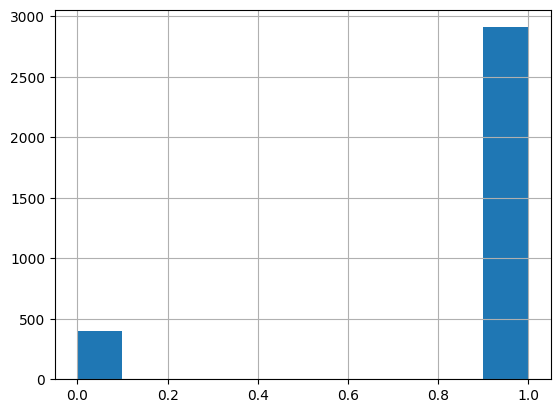

In [16]:
df_ac['label'].hist()

## Type classification multi-label-binarizer

In [17]:
df_tc.loc[13,'Type']

['F', 'L']

In [18]:
#need to extract the values from the list, in a way to pass it to the multilabelbinarizer
for i in range(len(df_tc)):
    x = df_tc.loc[i,'Type']
    if type(x) == list:
        df_tc.loc[i,'Type'] = ",".join([x[0],x[1]])


In [19]:
df_tc.loc[13,'Type']

'F,L'

In [20]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb_result = mlb.fit_transform([str(df_tc.loc[i,'Type']).split(',') for i in range(len(df_tc))])
df_tc_final = pd.concat([df_tc,pd.DataFrame(mlb_result,columns=list(mlb.classes_))],axis=1)
df_tc_final

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous,F,L
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A1,A,1,"In via preliminare, il Collegio prende in cons...",F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"In via preliminare, il Collegio prende in con...",1,0
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,NaN,NaN,Rule,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'...",0,1
2,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,NaN,NaN,Itpr,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Se il ricorso non è stato\n proposto da o ...,0,1
3,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A4,A,4,Nel caso di specie solo la ILDS ha presentato ...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Nel caso di specie solo la ILDS ha presentato...,1,0
4,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A5,A,5,come espressamente richiesto nel ricorso in...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,come\n espressamente richiesto nel ricorso...,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2905,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Sotto questo profilo i Compro Oro sono sottopo...,0,1
2906,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tale comunicazione ha luogo quando i destinata...,0,1
2907,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,"Il Ministro dell'interno, con decreto del 17 f...",0,1
2908,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,NaN,NaN,"[Class, Rule]",2021_6075_VAT_OPAM_2_1_PS_AN_C,Tra i soggetti destinatari del decreto sono ri...,0,1


In [21]:
df_tc_labels = df_tc_final[['F','L']]
df_tc_labels

,F,L
0,1,0
1,0,1
2,0,1
3,1,0
4,1,0
...,...,...
2905,0,1
2906,0,1
2907,0,1
2908,0,1


## Scheme classification multi-label-binarizer

In [22]:
#need to extract the values from the list, so convert to string, in a way to pass them to the multilabelbinarizer
for i in range(len(df_sc)):
    x = df_sc.loc[i,'Scheme']
    if type(x) == list:
        df_sc.loc[i,'Scheme'] = ",".join(x)


In [23]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb_result = mlb.fit_transform([str(df_sc.loc[i,'Scheme']).split(',') for i in range(len(df_sc))])
df_sc_final = pd.concat([df_sc,pd.DataFrame(mlb_result,columns=list(mlb.classes_))],axis=1)
df_sc_final

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,...,Aut,Class,Itpr,Lit,Prec,Princ,Psy,Rule,Syst,Tele
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1310,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1311,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1312,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,...,0,1,0,0,0,0,0,1,0,0


In [24]:
sc_classes = mlb.classes_
sc_classes

array(['Abs', 'Acon', 'Aut', 'Class', 'Itpr', 'Lit', 'Prec', 'Princ',
       'Psy', 'Rule', 'Syst', 'Tele'], dtype=object)

In [25]:
df_sc_labels = df_sc_final[mlb.classes_]
df_sc_labels

,Abs,Acon,Aut,Class,Itpr,Lit,Prec,Princ,Psy,Rule,Syst,Tele
0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1309,0,0,0,0,0,0,0,0,0,1,0,0
1310,0,0,0,0,0,0,0,0,0,1,0,0
1311,0,0,0,0,0,0,0,0,0,1,0,0
1312,0,0,0,1,0,0,0,0,0,1,0,0


<BarContainer object of 12 artists>

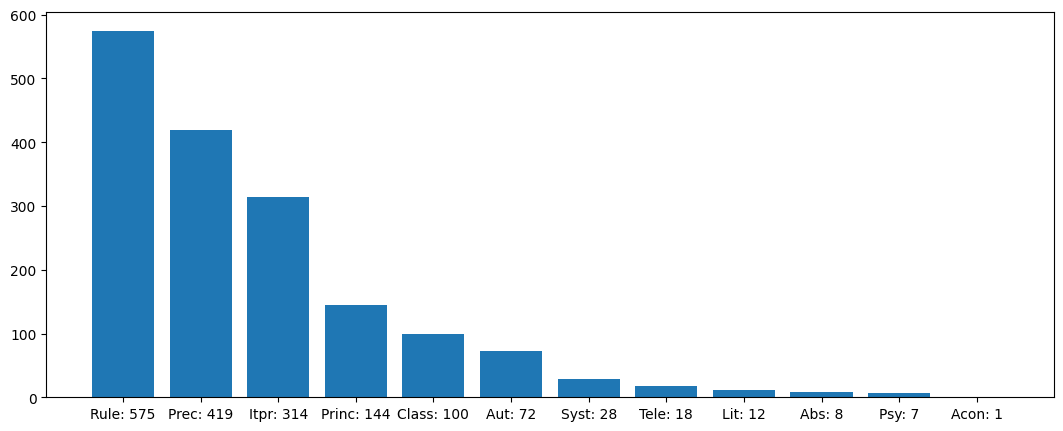

In [26]:
sc_label_count = df_sc_labels.sum().sort_values(ascending=False)
y = np.array(sc_label_count)
#x = np.array(sc_label_count.index)
#added values on x only for convenience
x = [sc_label_count.index[i] + ': ' + str(sc_label_count.iloc[i]) for i in range(len(sc_label_count))]
plt.figure(figsize=(13,5))
plt.bar(x, height=y)

In [27]:
bad_sc_classes = sc_label_count.index[sc_label_count < 15]
sc_classes = sc_label_count.index[sc_label_count >= 15]
print("Removing classes with low number of instances: "+', '.join(bad_sc_classes))
print("Keeping classes with good number of instances: "+', '.join(sc_classes))
good_sc_columns = np.setdiff1d(df_sc_final.columns, bad_sc_classes)
print("Remaining columns: "+', '.join(good_sc_columns))
df_sc_final = df_sc_final[df_sc_final["Scheme"].isin(sc_classes)][good_sc_columns]

Removing classes with low number of instances: Lit, Abs, Psy, Acon
Keeping classes with good number of instances: Rule, Prec, Itpr, Princ, Class, Aut, Syst, Tele
Remaining columns: ATT, Aut, Chain, Class, Document, FullChainID, INH, Id, Itpr, Name, Num, Prec, Previous, Princ, REPH, Rule, SFF, SUP, Scheme, Syst, Tele, Text, Type


# Data analysis

<Axes: >

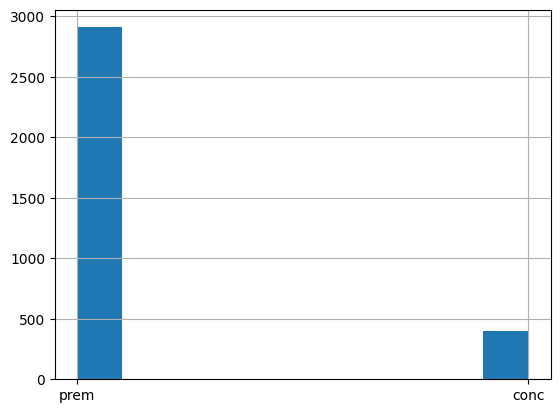

In [28]:
df_ac['Name'].hist()

In [29]:
print(f"There are {len(df_ac[df_ac['Name'] == 'prem'])} premises and {len(df_ac[df_ac['Name'] == 'conc'])} conclusions")

There are 2910 premises and 401 conclusions


<BarContainer object of 2 artists>

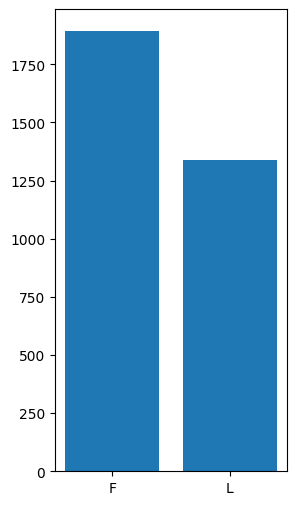

In [30]:
values = df_tc_labels.sum().sort_values(ascending=False)
y = np.array(values)
x = np.array(values.index)

plt.figure(figsize=(3,6))
plt.bar(x, height=y)

# Fixing seed

In [31]:
# Fix the random state for reproducibility
SEED = 27

def fix_seed(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_seed(SEED)

# Utils

## Train-Val-Test dataset splitting

In [32]:
def split_dataset(df, test_size=0.2):
    total_samples = df.shape[0]
    idx_train, idx_test = train_test_split(df['Document'].unique(),
                                      random_state=SEED,
                                      test_size=test_size)
    idx_train, idx_val = train_test_split(idx_train,
                                      random_state=SEED,
                                      test_size=idx_test.shape[0])
    df_train = df[df['Document'].isin(idx_train)]
    df_val = df[df['Document'].isin(idx_val)]
    df_test = df[df['Document'].isin(idx_test)]
    print('Number of training samples: {} ({}%)'.format(df_train.shape[0], 100*df_train.shape[0]/total_samples))
    print('Number of validation examples: {} ({}%)'.format(df_val.shape[0], 100*df_val.shape[0]/total_samples))
    print('Number of test samples: {} ({}%)'.format(df_test.shape[0], 100*df_test.shape[0]/total_samples))
    return df_train, df_val, df_test

## Save and load results
The results folder will contain the notebook, metrics and outputs for each seed.

In [33]:
results_folder = "results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

def results_to_csv(df_results, seed):
    '''
    Args:
        df_results: DataFrame with the all the scores
        seed: the used seed
    '''
    csv_path = f"{results_folder}/{seed}.csv"
    df_results.to_csv(path_or_buf=csv_path)

In [34]:
def results_from_csv(seed):
    '''
    Args:
        seed: the wanted seed
    '''
    file_path = f"results/{seed}.csv"
    df_results = pd.read_csv(file_path)

    return df_results

## PyTorch dataset

In [35]:
class CustomTorchDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

# Processing

## Encoding

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.corpus import stopwords

class BaselineVectorizer():
    def __init__(self, include_previous=False, max_features=None):
        self.tfidf = TfidfVectorizer(stop_words=stopwords.words('italian'),max_features=max_features)
        self.include_previous = include_previous
        self.fitted = False 
    
    def _clean_texts(self,df):
        texts = df["Previous"]+". "+df["Text"] if INCLUDE_PREVIOUS else df["Text"]
        cleaned = []
        for text in texts:
            text = re.sub("[^a-zA-Z0-9]"," ",text).lower().strip()
            cleaned.append(text)
        
        return cleaned
    
    def fit(self,df):
        cleaned_texts = self._clean_texts(df)
        self.tfidf.fit(cleaned_texts)
        self.fitted = True
        
    def transform(self,df):
        if not self.fitted:
            raise Exception("Vectorizer is not fitted.")
        cleaned_texts = self._clean_texts(df)
        return self.tfidf.transform(cleaned_texts)

In [37]:
def encode(tokenizer:PreTrainedTokenizer, df:pd.DataFrame, labels, scheme=False, include_previous=True):
    '''
    Encodes the dataset according to the BERT specifications.
    The method encodes the data in the following way:
        [CLS] previous [SEP] current [SEP]
        where -previous- is the previous (if any) sentence in the same argumentation chain
        and -current- is the current sentence
    '''
    print("Encoding...")
    encodings = tokenizer(
          list(df['Previous']), list(df['Text']), padding=True, truncation=True, max_length = 256
        ) if include_previous else tokenizer(
          list(df['Text']), padding=True, truncation=True, max_length = 256
        )

    input_ids, input_attention_mask = encodings['input_ids'], encodings['attention_mask']
    print(f"input shape: {np.shape(input_ids)}")
    if not scheme:
        encodings.update({'labels' : torch.LongTensor(labels.values)})
    else:
        encodings.update({'labels': torch.FloatTensor(labels.values)})
    encodings.pop('token_type_ids')

    print("Encoding complete")
    return encodings

## Model

In [38]:
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV

class SvmAcModel(SVC):
    """
    https://scikit-learn.org/stable/modules/svm.html#classification
    """
    def __init__(self):
        super(SvmAcModel, self).__init__(kernel="linear")

class SvmScModel(SVC):
    """
    https://scikit-learn.org/stable/modules/svm.html#multi-class-classification
    """
    def __init__(self):
        super(SvmScModel, self).__init__(kernel="linear", decision_function_shape='ovo')

In [39]:
from transformers import AutoModel
import torch.nn as nn

class ACModel(nn.Module):
    def __init__(self,checkpoint, output_size):
        super(ACModel, self).__init__()
        self.model = AutoModel.from_pretrained(checkpoint)
        self.output_size = output_size
        self.cl1 = nn.Linear(self.model.config.hidden_size, self.model.config.hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(self.model.config.hidden_size, self.output_size)

    def forward(self, input_ids, attention_mask):
        output  = self.model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        pooler_output = output.pooler_output
        x = self.cl1(pooler_output)
        x = self.relu(x)
        x = self.output(x)
        return x

class SCModel(nn.Module):

    def __init__(self,checkpoint, output_size):
        super(SCModel, self).__init__()
        self.model = AutoModel.from_pretrained(checkpoint)
        self.output_size = output_size
        self.cl1 = nn.Linear(self.model.config.hidden_size, self.model.config.hidden_size)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(self.model.config.hidden_size, self.output_size)


    def forward(self, input_ids, attention_mask):
        output  = self.model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        pooler_output = output.pooler_output
        x = self.cl1(pooler_output)
        x = self.relu(x)
        x = self.classifier(x)
        x = torch.sigmoid(x)
        return x


In [40]:

def getModel(model_checkpoint, num_labels, scheme=False):
    '''
    Creates and return an instance of the desired model with the correct tokenizer.
    '''
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    if scheme:
        model = SCModel(model_checkpoint, num_labels)
    else:
        model = ACModel(model_checkpoint, num_labels)

    return model, tokenizer

## Train

In [41]:
# Train one epoch
def train_epoch(model: torch.nn.Module,
          train_loader:torch.utils.data.DataLoader,
          device: torch.device,
          optimizer: torch.optim,
          criterion: torch.nn.Module,
          epoch: int) -> float:
    """Trains a neural network for one epoch.

    Args:
        model: the model to train.
        train_loader: the data loader containing the training data.
        device: the device to use to train the model.
        optimizer: the optimizer to use to train the model.
        epoch: the number of the current epoch.

    Returns:
        the cross entropy Loss value on the training data.
    """
    size_ds_train = len(train_loader.dataset)
    num_batches = len(train_loader)
    loss_score = []
    loop = tqdm(train_loader)
    #set training mode
    model.train()
    for idx_batch, batch in enumerate(loop):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        logits = model(input_ids,
                              attention_mask=attention_mask,
                        )
        loss = criterion(logits, labels)
        loss_score.append(loss.item())
        loss.backward()
        optimizer.step()
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

    loss_train = np.mean(loss_score)
    return loss_train

# Validate one epoch
def validate(model: torch.nn.Module,
             criterion: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             device: torch.device) -> float:
    """Evaluates the model.

    Args:
        model: the model to evalaute.
        data_loader: the data loader containing the validation data.
        device: the device to use to evaluate the model.

    Returns:
        the loss value on the validation data.
    """
    loss_score = []
    #set evaluation mode
    model = model.eval()
    with torch.no_grad():
        for idx_batch, batch in enumerate(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)
            loss_score.append(loss.item())
    loss_val = np.mean(loss_score)
    return loss_val

In [42]:
def training_loop(num_epochs: int,
                  optimizer: torch.optim,
                  criterion: torch.nn.Module,
                  model: torch.nn.Module,
                  lr: float,
                  loader_train: torch.utils.data.DataLoader,
                  loader_val : torch.utils.data.DataLoader = None,
                  model_dir = "models",
                  verbose: bool=True,
                  use_cuda = False) -> Dict:
    """Executes the training loop.

        Args:
            num_epochs: the number of epochs.
            optimizer: the optimizer to use.
            criterion: criterions used to calculate loss.
            model: the model to train.
            loader_train: the data loader containing the training data.
            loader_val: the data loader containing the validation data.
            model_dir: checkpoints folder.
            verbose: if true print the value of loss.

        Returns:
            A dictionary with the statistics computed during the train:
            the values for the train loss for each epoch.
            the values for the validation loss for each epoch.
            the time of execution in seconds for the entire loop.
    """
    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    loop_start = timer()
    train_losses_values = []
    val_losses_values = []

    best_epoch = 1

    for epoch in range(1, num_epochs + 1):
        time_start = timer()
        loss_train = train_epoch(model, loader_train, device,
                                           optimizer, criterion, epoch)
        if(loader_val != None):
            loss_val = validate(model, criterion, loader_val, device)
        else:
            loss_val = 0
        time_end = timer()
        train_losses_values.append(loss_train)
        val_losses_values.append(loss_val)

        torch.save(model.state_dict(), os.path.join(model_dir, 'epoch-{}.pt'.format(epoch)))
        best_epoch = np.argmin(val_losses_values)+1

        if verbose:
            print(f'Epoch: {epoch} '
                  f' Lr: {lr:.8f} '
                  f' Loss: Train = [{loss_train:.4f}] - Val = [{loss_val:.4f}] '
                  f' Time one epoch (s): {(time_end - time_start):.4f} ')

        if epoch >= 5:
            if loss_val > val_losses_values[-2] and loss_val> val_losses_values[-1]  :
                if verbose:
                    print("Early Stopping. Best epoch: {}".format(best_epoch))
                break

    loop_end = timer()
    time_loop = loop_end - loop_start
    if verbose:
        print(f'Time for {num_epochs} epochs (s): {(time_loop):.3f}')

    model.load_state_dict(torch.load(os.path.join(model_dir, 'epoch-{}.pt'.format(best_epoch))))

    return {'train_loss_values': train_losses_values,
            'val_loss_values' : val_losses_values,
            'time': time_loop}

In [43]:
def execute(lr: float,
            num_epochs: int,
            batch_size: int,
            num_labels: int,
            train_df: pd.DataFrame,
            train_labels: pd.DataFrame,
            val_df: pd.DataFrame,
            val_labels: pd.DataFrame,
            scheme = False,
            model_name="",
            model=None,
            tokenizer=None,
            use_cuda=True,
            include_previous=True
            ) ->Tuple[torch.nn.Module, any]:
    """Gets the model, does the encodings of the training and validation data using the
        tokenizer, and then executes the training loop.

    Args:
        lr: the learning rate.
        num_epochs: the number of epochs.
        batch_size: the batch size.
        data: training-val dataframe.
        data_labels: training-val labels dataframe.
        val_df: validation dataframe.
        model: the network to train.
        history: questions-answers history flag.
    """
    #train on full data
    #get the model and the tokenizer
    if not model_name == "":
        model, tokenizer = getModel(model_name, num_labels, scheme)
    if scheme:
        criterion = torch.nn.BCELoss()
    else:
        criterion = torch.nn.CrossEntropyLoss()
    #Start encodings
    #print(f'Train set:')
    train_encodings = encode(tokenizer, train_df, train_labels, scheme, include_previous=include_previous)
    val_encodings = encode(tokenizer, val_df, val_labels, scheme, include_previous=include_previous)
    print(f'ENCODING COMPLETE.')

    #create training dataset
    train_dataset = CustomTorchDataset(train_encodings)
    #create training dataloader
    data_loader_train = torch.utils.data.DataLoader(train_dataset,
                                        batch_size=batch_size,
                                        shuffle = True
                                        )
    #create validation dataset
    val_dataset = CustomTorchDataset(val_encodings)
    #create validation dataloader
    data_loader_val = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=batch_size,
                                          shuffle = False
                                          )
    #Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1.5e-2)
    print(f'STARTING TRAINING with complete data:')
    model_dir = 'model_data'
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    statistics = training_loop(num_epochs, optimizer, criterion, model,lr,
                              data_loader_train, data_loader_val, model_dir=model_dir, use_cuda=use_cuda)
    print(f'TRAINING COMPLETE.')

    return model, tokenizer, statistics

In [48]:
def executeTfIdfSvm(train_df: pd.DataFrame,
            train_labels: pd.DataFrame,
            val_df: pd.DataFrame,
            val_labels: pd.DataFrame,
            scheme = False,
            tokenizer=None,
            include_previous=True):
    tokenizer = BaselineVectorizer(include_previous=include_previous)
    tokenizer.fit(df_train)
    train_encodings = tokenizer.transform(df_train)
    val_encodings = tokenizer.transform(df_val)
    model = SvmScModel() if scheme else SvmAcModel()
    model.fit(train_encodings, train_labels)
    #val_predicted_labels = model.predict(val_encodings)
    #statistics = 
    return model, tokenizer

## Execution configuration

In [49]:
#model_checkpoint = 'bert-base-uncased'

model_checkpoint = "dlicari/Italian-Legal-BERT"

#parameters
lr = 5e-5
batch_size = 32
epochs = 5
#boolean used to distinguish between the AC and SC tasks
scheme = False
USE_CUDA = True
INCLUDE_PREVIOUS=True

In [50]:
#split dataset into training, validation and test sets
if scheme:
    df = df_sc_final
else:
    df = df_ac
df_train, df_val, df_test = split_dataset(df)
if not scheme:
    num_labels = len(df_train['label'].unique())
    train_labels = df_train['label']
    val_labels = df_val['label']
    test_labels = df_test['label']
else:
    train_labels = df_train[sc_classes]
    val_labels = df_val[sc_classes]
    test_labels = df_test[sc_classes]
    num_labels = train_labels.shape[1]

Number of training samples: 2021 (61.03896103896104%)
Number of validation examples: 696 (21.020839625490787%)
Number of test samples: 594 (17.940199335548172%)


## Baseline: TF-IDF + SVC

In [51]:
base_model, base_tokenizer = executeTfIdfSvm(
    df_train,
    train_labels,
    df_val,
    val_labels,
    scheme,
    include_previous=INCLUDE_PREVIOUS
)

## Actual model execution

In [52]:
model, tokenizer, statistics = execute(
    lr,
    epochs,
    batch_size,
    num_labels,
    df_train,
    train_labels,
    df_val,
    val_labels,
    scheme,
    model_name=model_checkpoint,
    use_cuda=USE_CUDA,
    include_previous=INCLUDE_PREVIOUS
)

tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/474k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dlicari/Italian-Legal-BERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Encoding...
input shape: (2021, 256)
Encoding complete
Encoding...
input shape: (696, 256)
Encoding complete
ENCODING COMPLETE.
STARTING TRAINING with complete data:


  0%|          | 0/64 [00:00<?, ?it/s]/tmp/ipykernel_34/2237618980.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1: 100%|██████████| 64/64 [01:16<00:00,  1.20s/it, loss=0.436] 


Epoch: 1  Lr: 0.00005000  Loss: Train = [0.2018] - Val = [0.1520]  Time one epoch (s): 87.1379 


Epoch 2: 100%|██████████| 64/64 [01:24<00:00,  1.31s/it, loss=0.00757]


Epoch: 2  Lr: 0.00005000  Loss: Train = [0.1051] - Val = [0.1454]  Time one epoch (s): 94.6626 


Epoch 3: 100%|██████████| 64/64 [01:24<00:00,  1.31s/it, loss=0.0028] 


Epoch: 3  Lr: 0.00005000  Loss: Train = [0.0549] - Val = [0.1380]  Time one epoch (s): 94.7872 


Epoch 4: 100%|██████████| 64/64 [01:24<00:00,  1.31s/it, loss=0.000769]


Epoch: 4  Lr: 0.00005000  Loss: Train = [0.0282] - Val = [0.1832]  Time one epoch (s): 94.8036 


Epoch 5: 100%|██████████| 64/64 [01:24<00:00,  1.31s/it, loss=0.000343]


Epoch: 5  Lr: 0.00005000  Loss: Train = [0.0112] - Val = [0.1933]  Time one epoch (s): 94.8238 
Time for 5 epochs (s): 469.257
TRAINING COMPLETE.


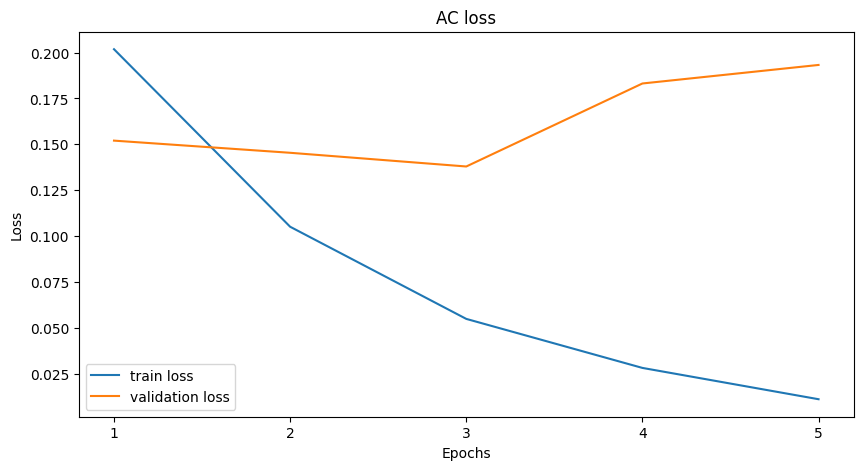

In [53]:
plt.figure(figsize=(10,5))
plt.title("SC loss" if scheme else "AC loss")
plt.plot(statistics['train_loss_values'],label="train loss")
plt.plot(statistics['val_loss_values'],label="validation loss")
plt.xlabel("Epochs")
plt.xticks(np.arange(epochs), np.arange(1, epochs+1, 1))
plt.ylabel("Loss")
plt.legend()
plt.show()

## Evaluation

### AC Evaluation

In [54]:
def predict(model, data_loader, use_cuda=True):
    '''
    Args:
      model: trained model.
      data_loader: source of evaluation data.

    Returns:
      pred_emo: predicted emotions.
      pred_tri: predicted thresholded triggers.
      pred_tri_orig: raw model's trigger predictions.
    '''
    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu')
    model.eval()
    model.to(device)
    predictions = []
    with torch.no_grad():
        for step_num, batch in tqdm(enumerate(data_loader)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            #labels_emo = batch['labels'].to(device)
            output = model(input_ids, attention_mask=attention_mask)
            pred= output
            pred = pred.cpu().detach().numpy()
            predictions.append(np.argmax(pred,axis=-1))
    predictions = np.concatenate(predictions)

    return predictions

In [56]:
base_test_encodings = base_tokenizer.transform(df_test)
train_encodings = encode(tokenizer, df_train, train_labels, include_previous=INCLUDE_PREVIOUS)
val_encodings = encode(tokenizer, df_val, val_labels, include_previous=INCLUDE_PREVIOUS)
test_encodings = encode(tokenizer,df_test,test_labels, include_previous=INCLUDE_PREVIOUS)
print(f'ENCODING COMPLETE.')



Encoding...
input shape: (2021, 256)
Encoding complete
Encoding...
input shape: (696, 256)
Encoding complete
Encoding...
input shape: (594, 256)
Encoding complete
ENCODING COMPLETE.


In [58]:
if not scheme:
    #create val dataset
    val_dataset = CustomTorchDataset(val_encodings)
    #create val dataloader
    data_loader_val = torch.utils.data.DataLoader(val_dataset,
                                      batch_size=batch_size,
                                      shuffle = False)
    y_true = val_labels
    y_pred = predict(model,data_loader_val)
    print('/n'+""+classification_report(y_true, y_pred))

0it [00:00, ?it/s]/tmp/ipykernel_34/2237618980.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
22it [00:11,  1.99it/s]

/n              precision    recall  f1-score   support

           0       0.83      0.86      0.84        90
           1       0.98      0.97      0.98       606

    accuracy                           0.96       696
   macro avg       0.90      0.91      0.91       696
weighted avg       0.96      0.96      0.96       696



In [59]:
if not scheme:
    y_true = test_labels
    
    y_pred = base_model.predict(base_test_encodings)
    print("\n Baseline: \n"+classification_report(y_true, y_pred))
    
    #create test dataset
    test_dataset = CustomTorchDataset(test_encodings)
    #create test dataloader
    data_loader_test = torch.utils.data.DataLoader(test_dataset,
                                      batch_size=batch_size,
                                      shuffle = False)
    y_pred = predict(model,data_loader_test)
    print("\n Actual model: \n"+classification_report(y_true, y_pred))


 Baseline: 
              precision    recall  f1-score   support

           0       0.95      0.66      0.78        79
           1       0.95      0.99      0.97       515

    accuracy                           0.95       594
   macro avg       0.95      0.83      0.87       594
weighted avg       0.95      0.95      0.95       594



0it [00:00, ?it/s]/tmp/ipykernel_34/2237618980.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
19it [00:09,  2.02it/s]


 Actual model: 
              precision    recall  f1-score   support

           0       0.83      0.81      0.82        79
           1       0.97      0.97      0.97       515

    accuracy                           0.95       594
   macro avg       0.90      0.89      0.90       594
weighted avg       0.95      0.95      0.95       594



In [ ]:
#score = f1_score(y_true, y_pred, labels=df_test['label'].unique(), average='macro')

### SC Evaluation

In [ ]:
def evaluate(model, data_loader, use_cuda=True):
    predictions = []
    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu')
    model.eval()
    model.to(device)
    loop = tqdm(data_loader)
    with torch.no_grad():
        for batch in loop:
            pred = model(batch['input_ids'].to(device), attention_mask = batch["attention_mask"].to(device))
            pred = pred.cpu().detach().numpy()
            predictions.append(pred)
    predictions = np.concatenate(predictions)
    return predictions

In [ ]:
test_encodings = encode(tokenizer,df_test,test_labels,scheme,include_previous=INCLUDE_PREVIOUS)
#create test dataset
test_dataset = CustomTorchDataset(test_encodings)
#create test dataloader
data_loader_test = torch.utils.data.DataLoader(test_dataset,
                                    batch_size=batch_size,
                                    shuffle = False)


In [ ]:
from sklearn.metrics import classification_report,f1_score

if scheme:
    predictions = evaluate(model, data_loader_test)
    y_pred = np.where(predictions<0.5, 0., 1.)
    y_true = np.array(test_labels)
    print('/n'+""+classification_report(y_true, y_pred,target_names = sc_classes))